# Discriminant Analysis of Principal Components
## Temporal Structure of Blackfin tuna

In [2]:
library(adegenet) 
library(dplyr)
library(tidyr)
library(magrittr)
library(ggpubr)
set.seed(6969)
my_pal <- c("#f1c232", "#d08120", "#54438a", "#655595", "#2a2145","#66b2b2", "#008080", "#006666", "#ff8181")

Load in the file(s)

In [3]:
infile <- "../inputfiles/bft.kinless.gen"
bft <- read.genepop(infile, ncode = 3L, quiet = T)
metadata <- read.csv("../inputfiles/bft.strata", sep = ",", header = T)

Adding Population-Year as the `pop` information

In [4]:
metadata$locyear <- paste(metadata$pop4, metadata$year, sep = "-")

pop(bft) <- metadata$locyear
yearID <- metadata$year
localID <- metadata$pop4
regionID <- metadata$pop3

### Final Optimal number of Principal Components
Use cross validation to determine optimal number of PCs to keep. The first cross-validation is performed between 1 and 300 in increments of 10. This can be considered a "coarse" search.

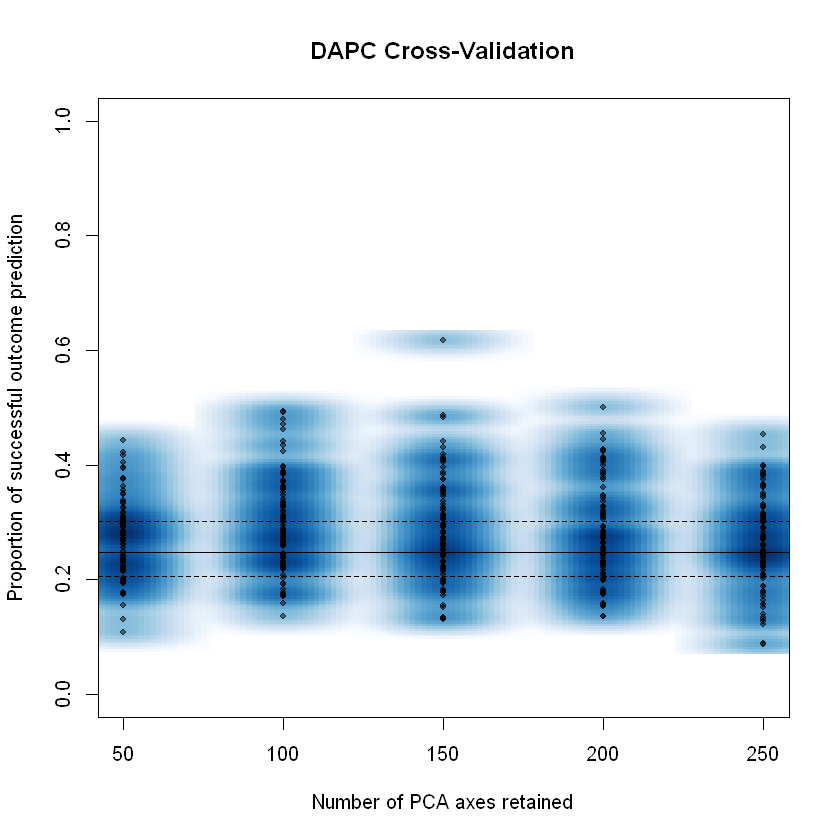

In [9]:
crossval <- xvalDapc(tab(bft, NA.method="mean"), regionID, n.pca.max=300, n.rep=100,  parallel = "multicore", ncpus = 4)
cv.pc <- crossval$`Number of PCs Achieving Highest Mean Success`

In [49]:
cv.pc <- as.numeric(cv.pc)
cv.range <- (cv.pc - 10):(cv.pc + 10)
cv.range

[1]  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
[20] 109 110

It suggests around 100 PCs, so now perform a "fine" search of 100 +- 10 in increments of 1

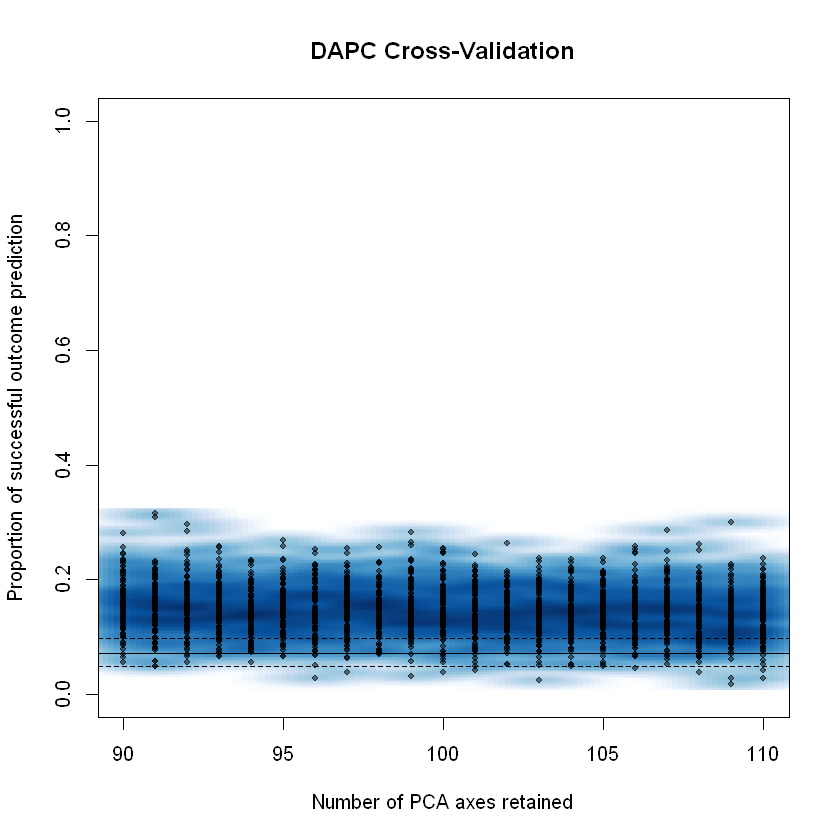

In [11]:
dapc <- xvalDapc(tab(bft, NA.method="mean"), pop(bft), n.pca=cv.range, n.rep=100,  parallel = "multicore", ncpus = 4)

Save the optimal PC number

In [12]:
pcval <- dapc$DAPC$n.pca
print(paste("Optimal PC:", pcval))

[1] "Optimal PC: 90"


### K-means clustering
Iteratively perform K-means clustering from K-values 1 to 9, each value of K performed 50 times.

In [6]:
maxK <- 9
myMat <- matrix(nrow=50, ncol=maxK)
colnames(myMat) <- 1:maxK
for(i in 1:nrow(myMat)){
  grp <- find.clusters(bft, n.pca = pcval, choose.n.clust = FALSE,  max.n.clust = maxK)
  myMat[i,] <- grp$Kstat
}

Format the matrix for plotting

In [7]:
k_df <- reshape2::melt(myMat)
colnames(k_df)[1:3] <- c("Group", "K", "BIC")
k_df$K <- as.factor(k_df$K)

Plot the results

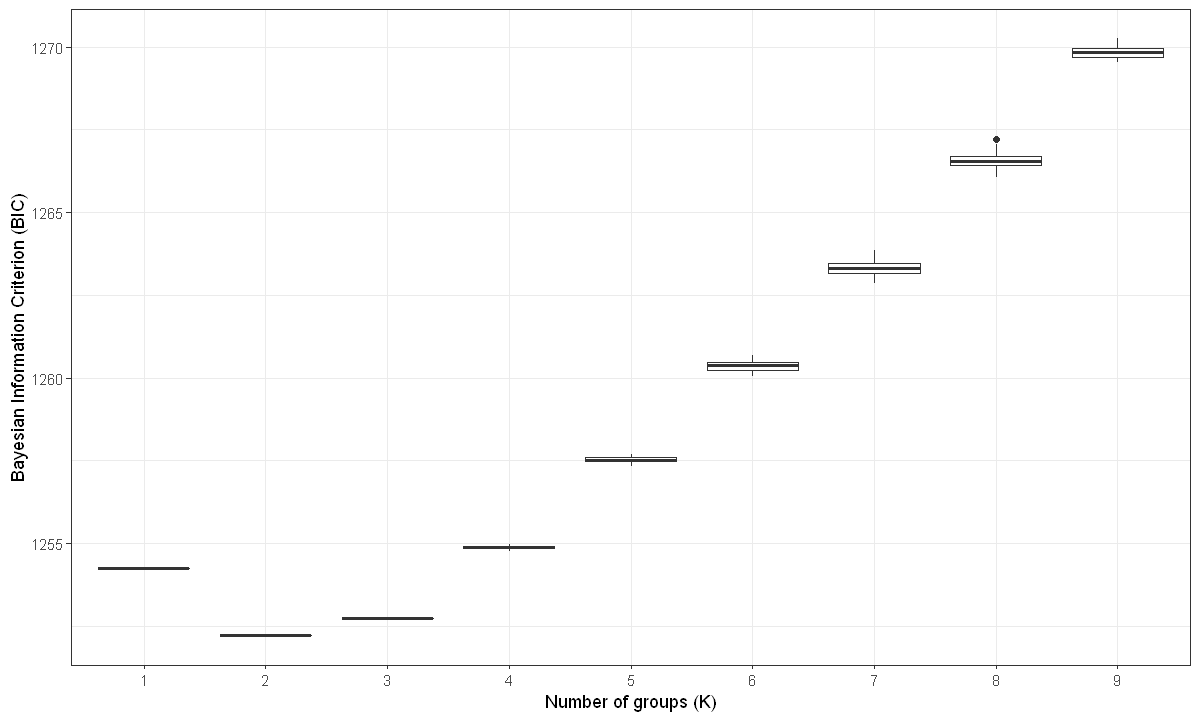

In [8]:
options(repr.plot.width=10, repr.plot.height=6)
k.plot <- k_df %>% 
  ggplot(aes(x = K, y = BIC)) +
  geom_boxplot() +
  theme_bw() +
  ylab("Bayesian Information Criterion (BIC)") +
  xlab("Number of groups (K)")

k.plot

Get the population assignments from K-means clustering with K = 2

In [9]:
kmeans <- find.clusters(bft, n.pca = pcval,  n.clust = 2)

Retain _de novo_ k-means assignments to use for the DAPC

In [10]:
kmeans.grp <- kmeans$grp

### DAPC
Perform DAPC again, this time using the optimal PC and the K-means assignments

In [11]:
dapc.res <- dapc(bft, pop = kmeans.grp, n.pca = pcval, n.da = 5)

## Plot by Locality

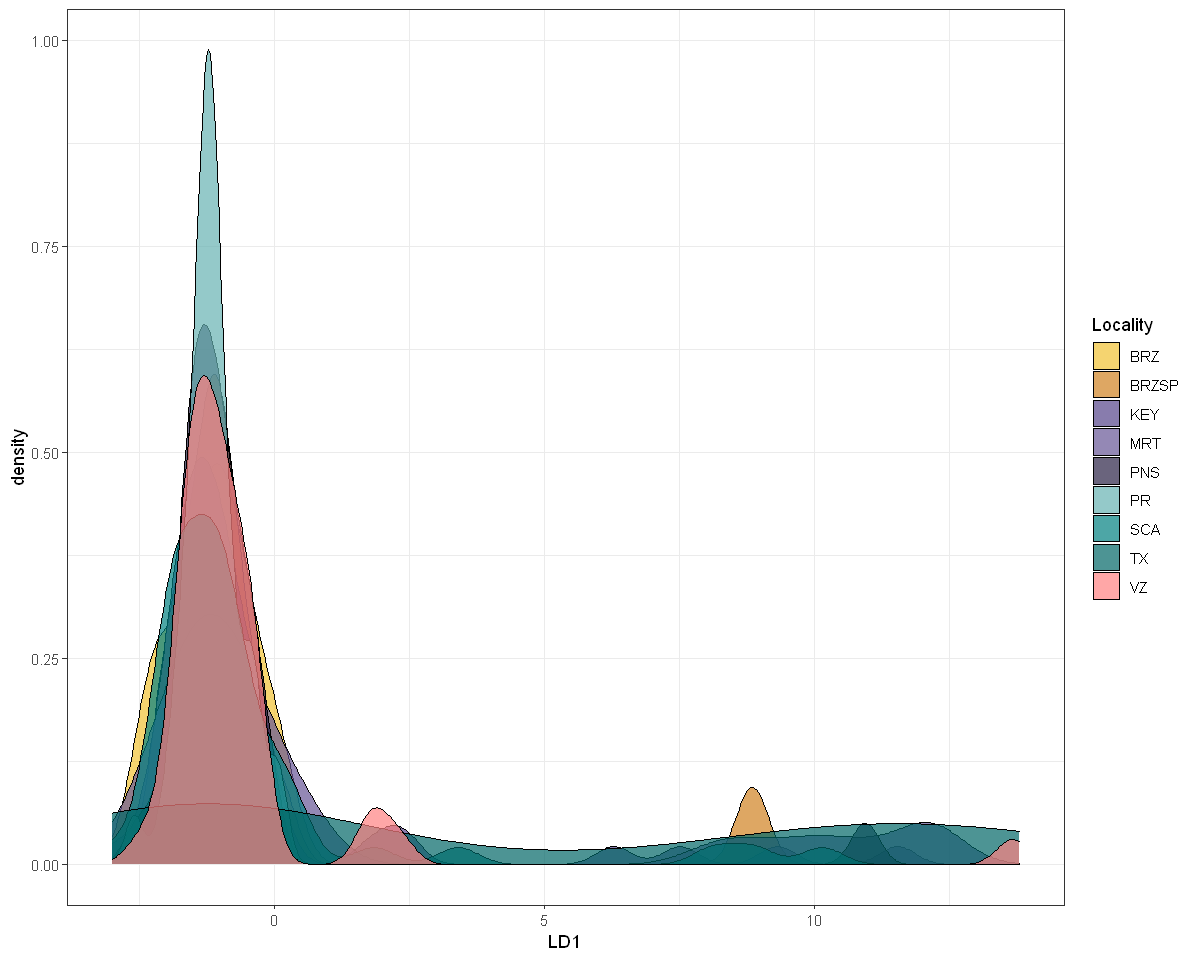

In [35]:
options(repr.plot.width=10, repr.plot.height=8)
dapc.df <- data.frame(LD1 = dapc.res$ind.coord, Year = as.character(yearID), Locality = localID, Region = regionID)
dapc.plot <- ggplot(dapc.df, aes(LD1, fill = Locality)) +
    geom_density(alpha = 0.7) +
    theme_bw() +
    scale_fill_manual(values = my_pal)
dapc.plot

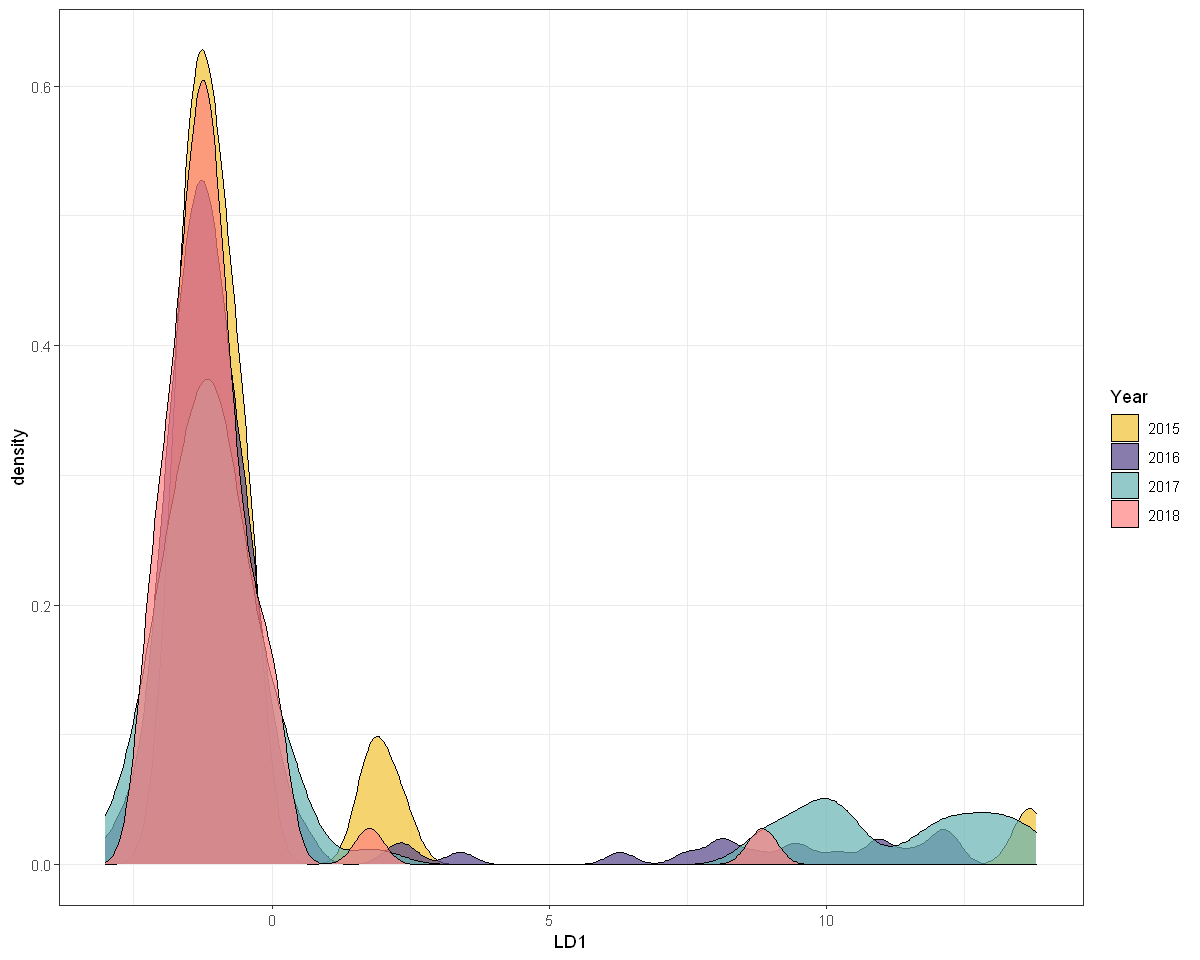

In [38]:
dapc.yr.plot <- ggplot(dapc.df, aes(LD1, fill = Year)) +
    geom_density(alpha = 0.7) +
    theme_bw() +
    scale_fill_manual(values = my_pal[c(1,3,6,9)])
dapc.yr.plot

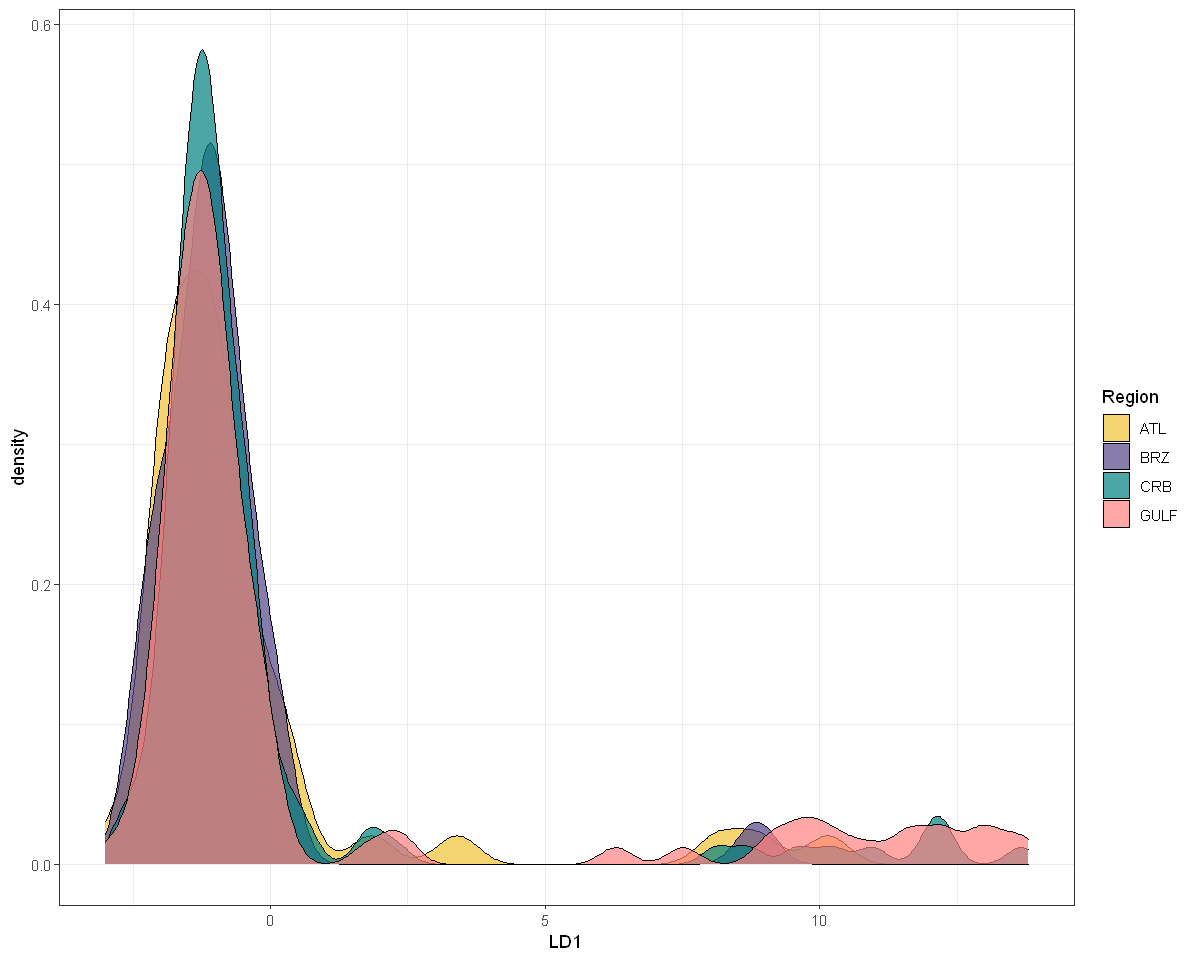

In [32]:
dapc.rg.plot <- ggplot(dapc.df, aes(LD1, fill = Region)) +
    geom_density(alpha = 0.7) +
    theme_bw() +
    scale_fill_manual(values = my_pal[c(1,3,7,9)])
dapc.rg.plot

### Posterior Membership Plot
Making the stacked barplot, similar to how STRUCTURE results are presented

In [17]:
tmp <- as.data.frame(dapc.res$posterior)
tmp <- cbind(indNames(bft), bft$pop, tmp)
names(tmp) <- c("name", "origin", "1", "2")
tmp$origin <- metadata$pop4
tmp$origin <- paste(metadata$pop4, metadata$year, sep = "\n")
assignments <- pivot_longer(tmp, c(-name, -origin), names_to = "assignment", values_to = "posterior")
head(assignments)

name,origin,assignment,posterior
<chr>,<chr>,<chr>,<dbl>
BRZ_1261,BRZ 2016,1,1.000000e+00
BRZ_1261,BRZ 2016,2,8.960957e-29
BRZ_1269,BRZ 2016,1,1.000000e+00
BRZ_1269,BRZ 2016,2,3.533993e-37
BRZ_1270,BRZ 2016,1,1.000000e+00
BRZ_1270,BRZ 2016,2,1.607990e-38


Plot the data

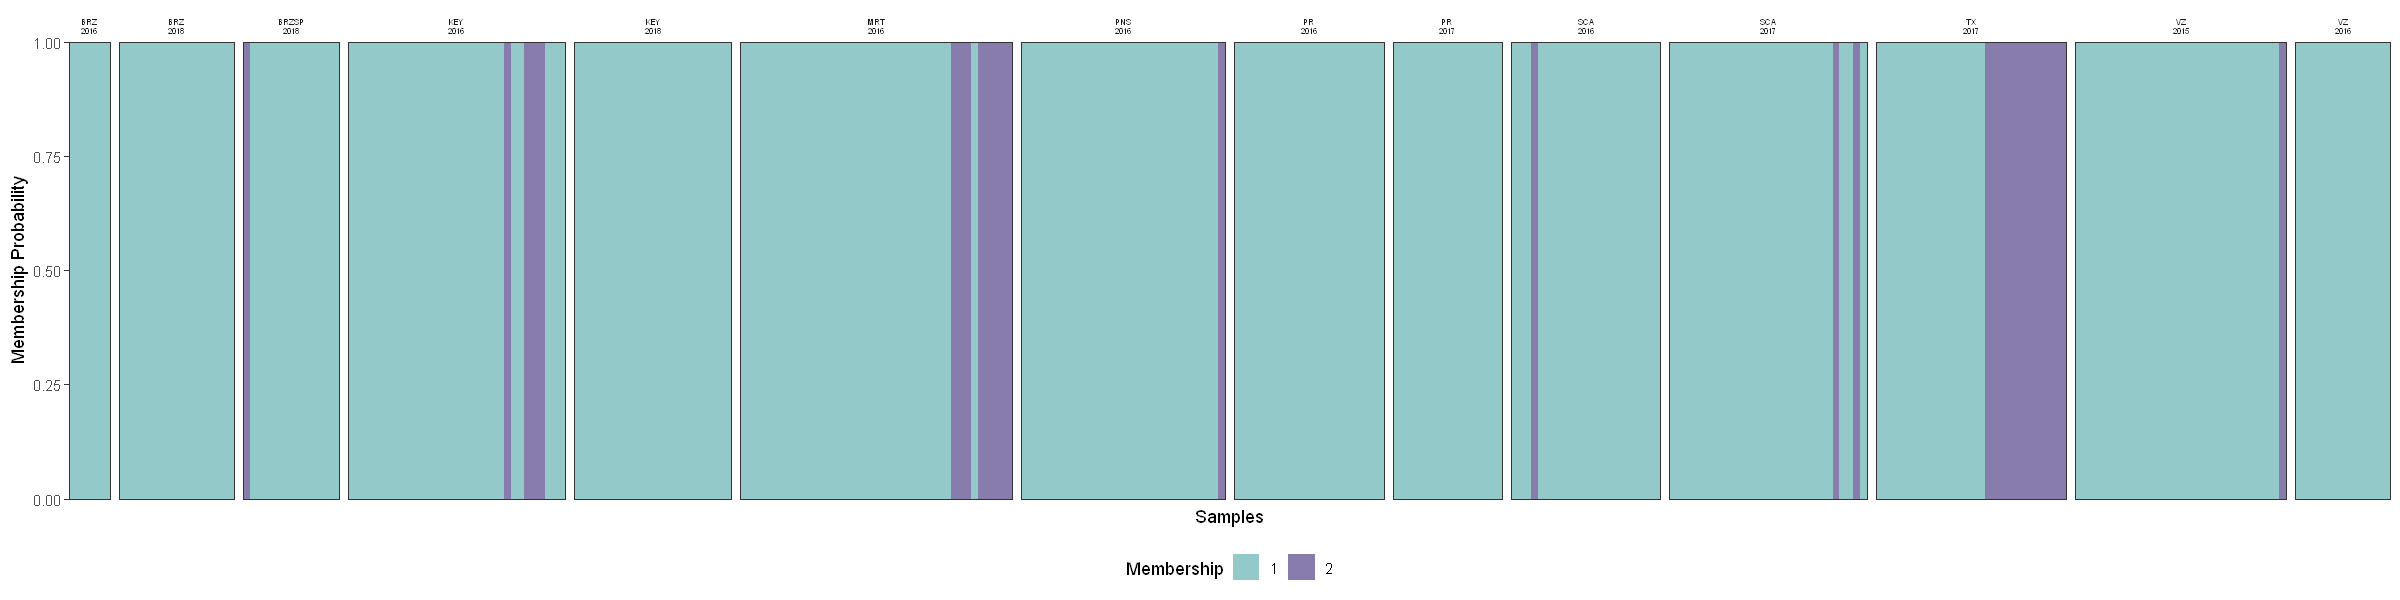

In [19]:
options(repr.plot.width=20, repr.plot.height=5)
posterior_plot <- assignments %>% 
  ggplot(aes(x = name, y = posterior, fill = assignment)) +
  geom_bar(stat = "identity", width = 1.0, alpha = 0.7) +
  scale_fill_manual(values =  my_pal[c(6,3)]) +
  ylab( "Membership Probability") +
  xlab("Samples") +
  facet_grid(~origin, scales = "free_x", space = "free" ) + 
  theme_bw() +
  guides(fill=guide_legend(title="Membership")) +
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        strip.background = element_blank(),
        strip.text.x = element_text(size = 5),
        legend.position = "bottom") +
  coord_cartesian(ylim = c(0, 1), expand = FALSE, clip = "off")

posterior_plot

Combine all three as a single plot

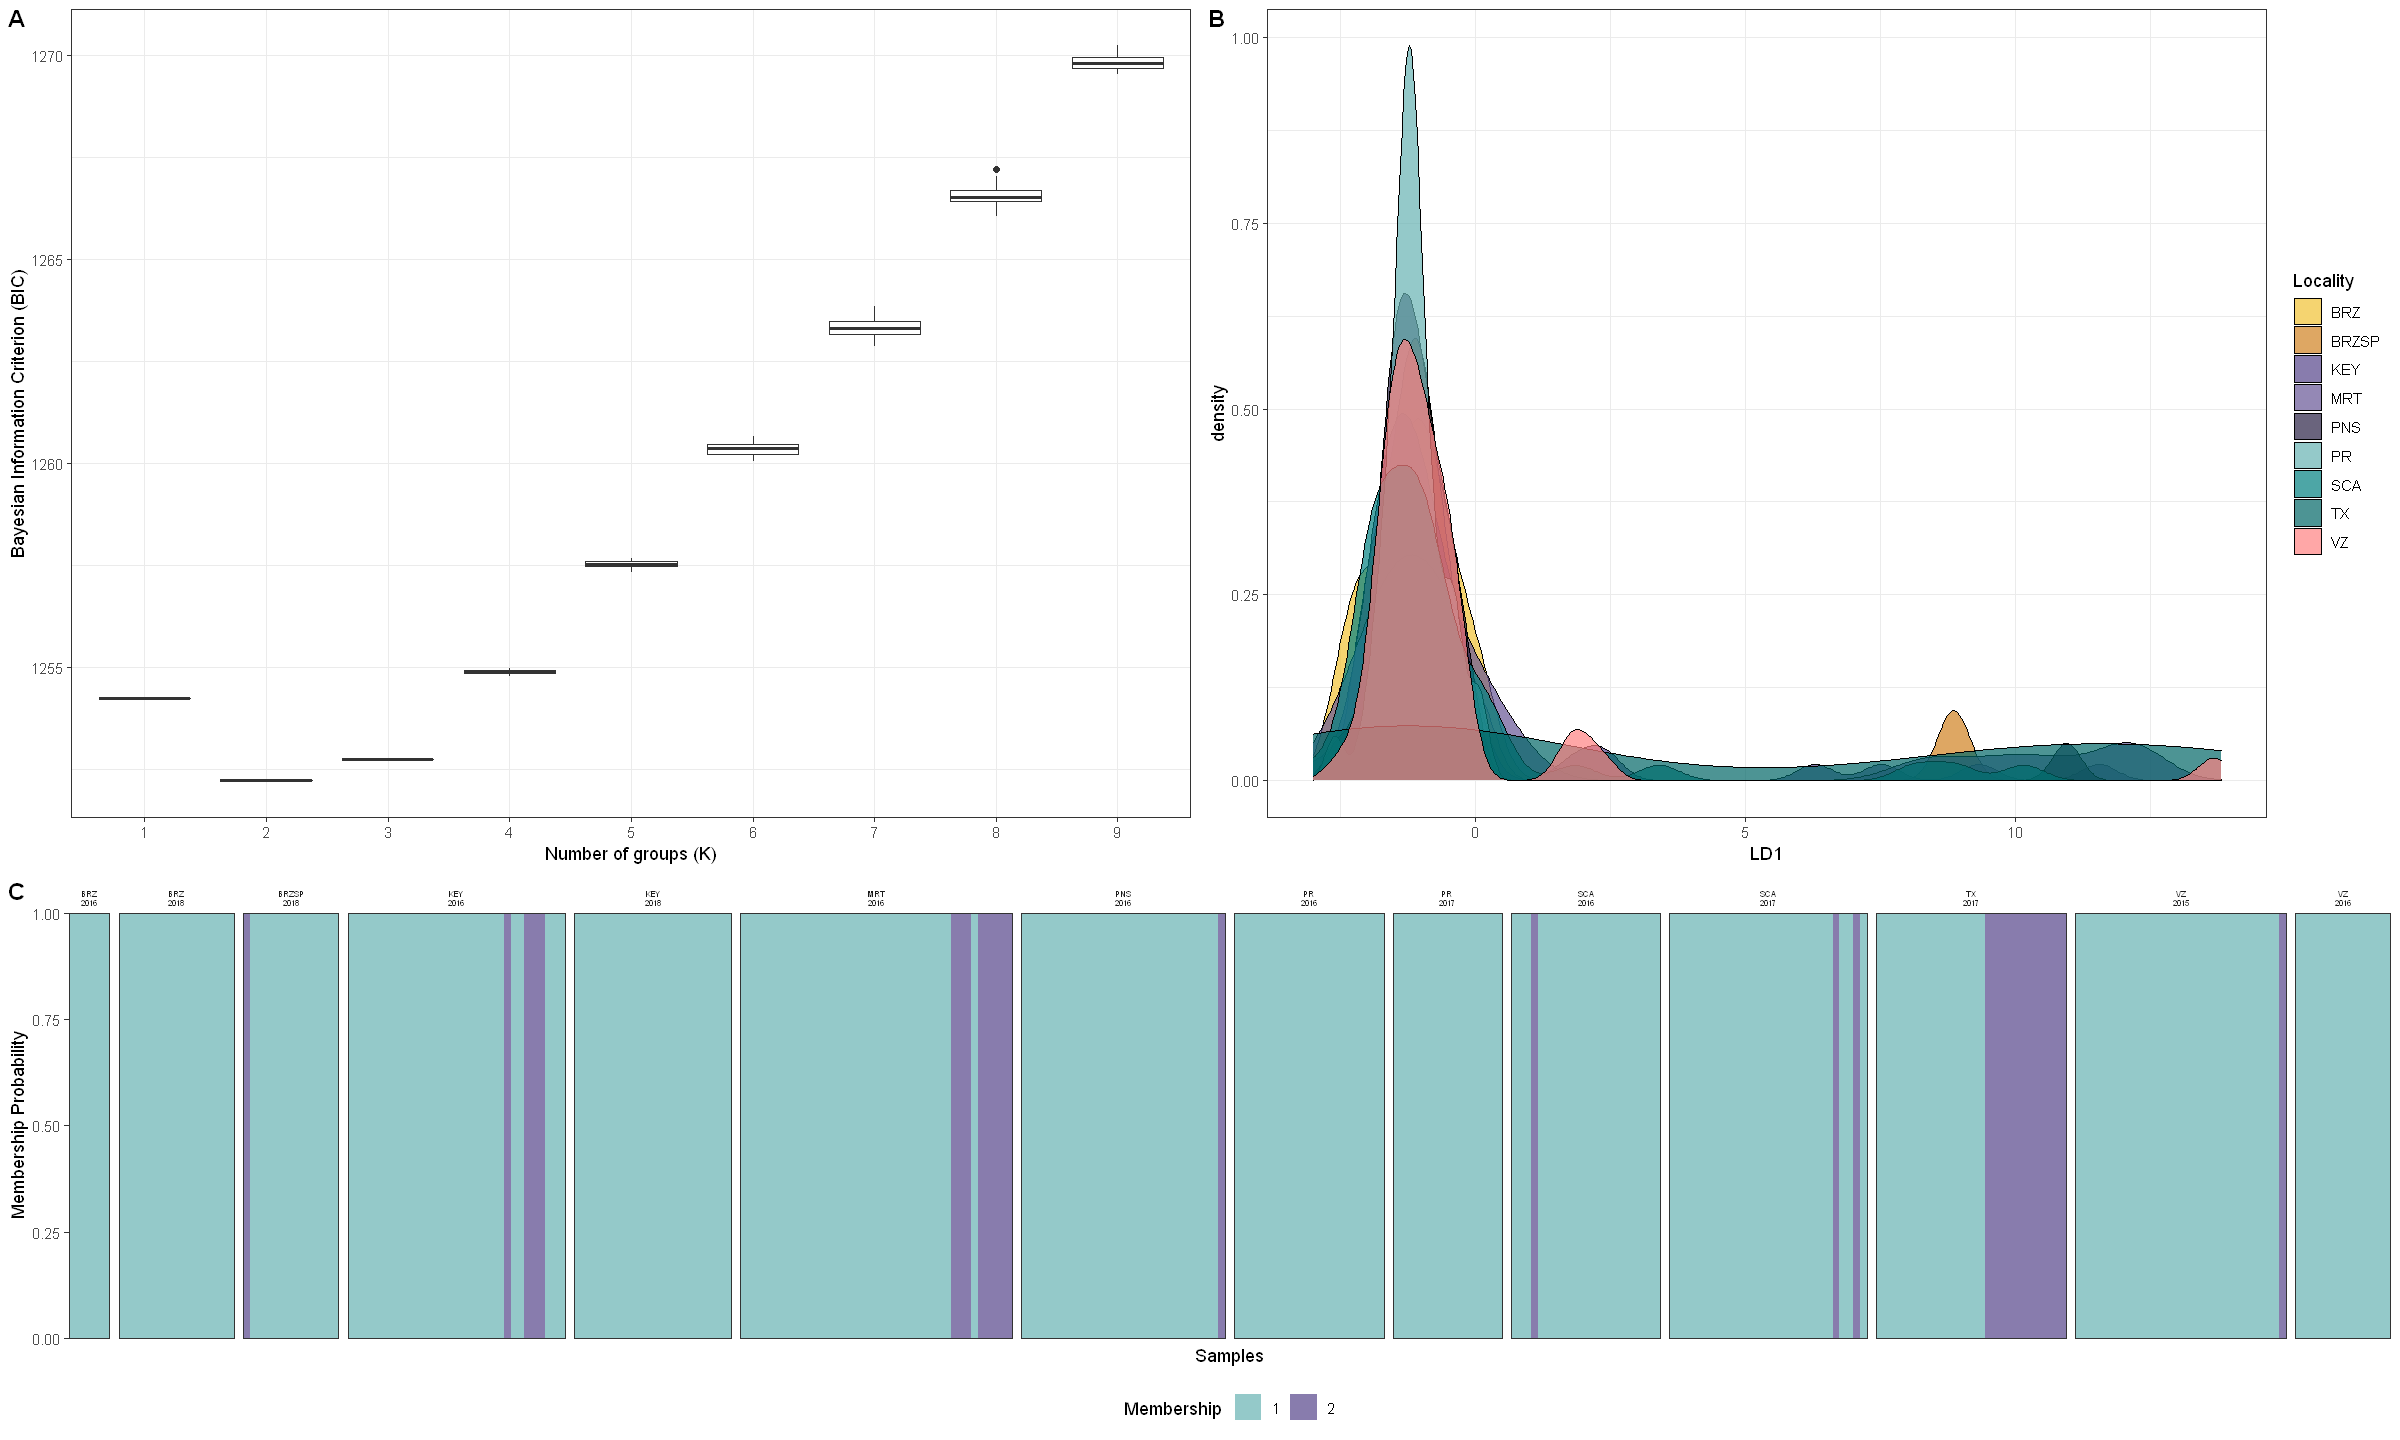

In [20]:
options(repr.plot.width=20, repr.plot.height=12)
ggarrange(
  ggarrange(
    k.plot,
    dapc.plot2,
    ncol = 2, 
    labels = c("A", "B")
  ),
  posterior_plot,
  nrow = 2,
  labels = c("", "C"),
  heights = c(2, 1.3)
)

Save it

In [21]:
ggsave("dapc.png", height = 7, width = 14, units = "in")